## Conformalized Survival Analysis with Right-Censoring

This notebook demonstrates the use of DR-COSARC on real data sets.

In [10]:
# Load required libraries
suppressMessages(library(tidyverse))
suppressMessages(library(gridExtra))
library(survival)
library(ggsurvfit)
library(grf)
library(cfsurvival)
suppressMessages(library(hdf5r))

## Load the data

In [123]:
data.name <- "PBC"
data <- read_csv(sprintf("../../data/data_csv/%s.csv", data.name), show_col_types = FALSE)

data 

time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
400,1,1,58.76523,f,1,1,1,1.0,14.5,261.0,2.60,156,1718.0,137.95,172,190,12.2,4
4500,0,1,56.44627,f,0,1,1,0.0,1.1,302.0,4.14,54,7394.8,113.52,88,221,10.6,3
1012,1,1,70.07255,m,0,0,0,0.5,1.4,176.0,3.48,210,516.0,96.10,55,151,12.0,4
1925,1,1,54.74059,f,0,1,1,0.5,1.8,244.0,2.54,64,6121.8,60.63,92,183,10.3,4
1504,1,2,38.10541,f,0,1,1,0.0,3.4,279.0,3.53,143,671.0,113.15,72,136,10.9,3
2503,1,2,66.25873,f,0,1,0,0.0,0.8,248.0,3.98,50,944.0,93.00,63,251,11.0,3
1832,0,2,55.53457,f,0,1,0,0.0,1.0,322.0,4.09,52,824.0,60.45,213,204,9.7,3
2466,1,2,53.05681,f,0,0,0,0.0,0.3,280.0,4.00,52,4651.2,28.38,189,373,11.0,3
2400,1,1,42.50787,f,0,0,1,0.0,3.2,562.0,3.08,79,2276.0,144.15,88,251,11.0,2


In [124]:
# Function to identify columns with a single value (factor or character)
get_single_value_columns <- function(df) {
  df %>%
    select(where(~ is.factor(.) || is.character(.))) %>%  # Select factor or character columns
    keep(~ length(unique(.)) == 1) %>%                   # Keep columns with one unique value
    names()                                               # Return column names
}

get_single_value_columns(data)

character(0)

In [125]:
source("../conf_surv/utils_real_data.R")

# Available datasets:
# VALCT: Lung cancer trial data (137 obs, 6 vars, from survival::veteran).
# PBC: Liver disease data (137 obs, 6 vars, from survival::pbc, NAs imputed).
# GBSG: Breast cancer data (2232 obs, 7 vars, combined train/test).
# METABRIC: Breast cancer clinical data (1981 obs, 26 vars).

data.name <- "METABRIC"

data <- read_csv(sprintf("../../data/data_csv/%s.csv", data.name), show_col_types = FALSE)

dim(data)

# Data features
num_features <- ncol(data) - 2

[1] 1981   27

In [126]:
# Split the dataset
split_result <- split_data(data, train_prop = 0.6, cal_prop = 0.2, test_prop = 0.2, seed = 123)

# Access subsets
data.train <- split_result$train
data.cal <- split_result$cal
data.test <- split_result$test

## Explore the data

In [127]:
# Summarize data under type-I censoring
data.train |>
    summarise(Observations=n(), Events = sum(status), 
              `Proportion censored`=mean(status==0),
              `Median observed time`=median(time),
              `Median observed event time`=median(time[status]))

Observations,Events,Proportion censored,Median observed time,Median observed event time
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1189,696,0.4146341,112.6667,97.83333


We can also plot the Kaplan-Meier curve

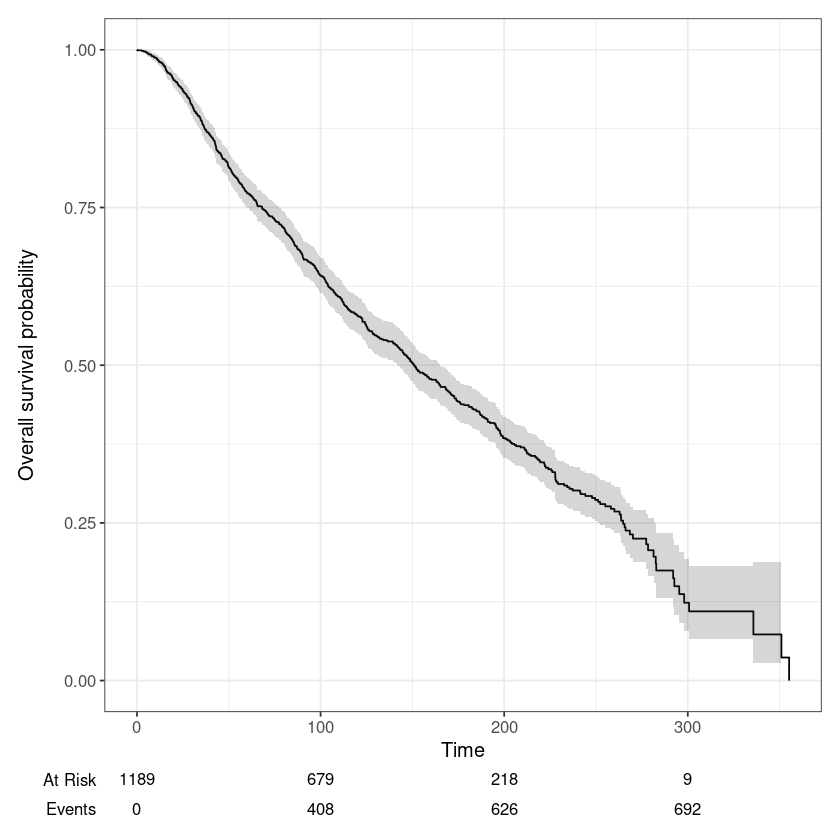

In [128]:
survfit2(Surv(time, status) ~ 1, data = data.train) |> 
  ggsurvfit() +
  labs(
    x = "Time",
    y = "Overall survival probability"
  ) +
  add_confidence_interval() +
  add_risktable()

## Training (survival model)

Fit a survival model using the training data.

In [129]:
source("../conf_surv/utils_survival.R")

model_type = "grf"

if(model_type=="grf") {
    # Instantiate GRF survival forest
    surv_model <- GRF_SurvivalForestWrapper$new()
} else if (model_type=="survreg") {
    # Instantiate Cox proportional hazards model
    surv_model <- SurvregModelWrapper$new(dist="lognormal")
} else if (model_type=="rf") {
    # Instantiate random forest survival model
    surv_model <- randomForestSRC_SurvivalWrapper$new()
} else if (model_type=="cox") {
    # Instantiate random forest survival model
    surv_model <- CoxphModelWrapper$new()
} else {
    stop("Unknown model type!")
}

surv_model$fit(Surv(time, status) ~ ., data = data.train)

Let us now visualize the predicted survival curves for two individuals.

In [130]:
source("../conf_surv/utils_plotting.R")

idx.predict <- c(1:4)
predictions = surv_model$predict(data.cal[idx.predict,])
plot_survival_curves(predictions)

ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels


Predict survival time quantiles

In [55]:
# Predict survival time quantiles
surv_model$predict_quantiles(data.cal[idx.predict,], probs = c(0.1, 0.5, 0.9))

ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels


## Training (censoring model)

Let's start by visualizing the true censoring distribution

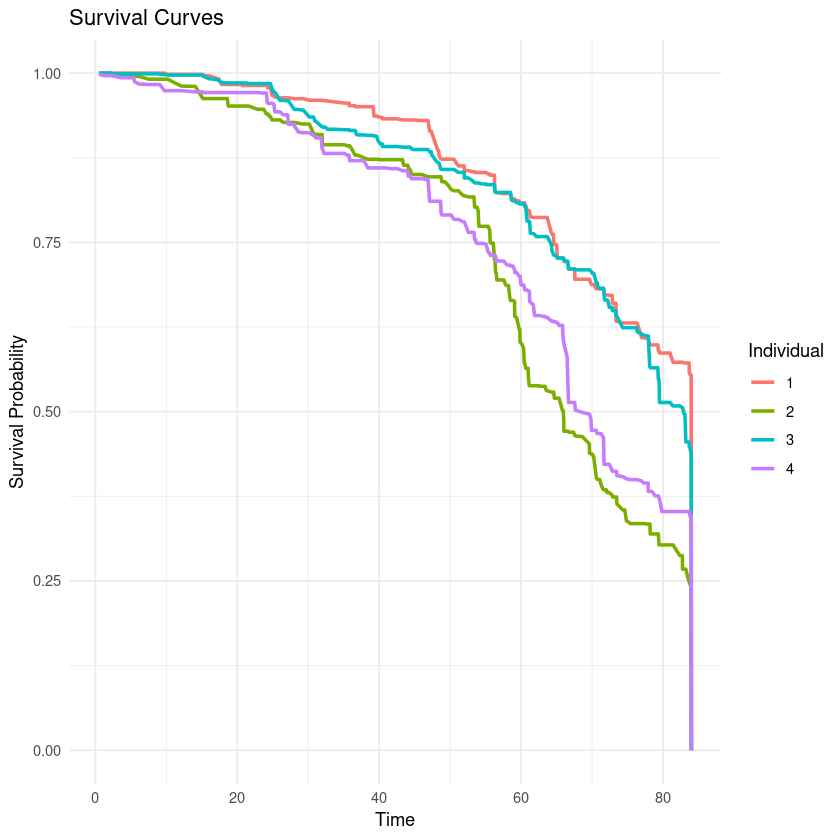

In [9]:
source("../conf_surv/utils_censoring.R")

# List of covariates to use for censoring model
# If we have prior information that some covariates are useless, we can drop them. This helps avoid overfitting, improving the performance of our prototype.
num_feat_censor <- 10
use.covariates <- paste("X",1:min(num_features,num_feat_censor),sep="")

# Initialize a base model for the censoring distribution
cens_base_model <- GRF_SurvivalForestWrapper$new(use_covariates=use.covariates)
#cens_base_model <- SurvregModelWrapper$new(dist="lognormal", use_covariates=use.covariates)
#cens_base_model <- CoxphModelWrapper$new(use_covariates=use.covariates)
#cens_base_model <- randomForestSRC_SurvivalWrapper$new(use_covariates=use.covariates)

# Create an instance of the CensoringModel class with the model
cens_model <- CensoringModel$new(model = cens_base_model)

# Fit the censoring distribution
cens_model$fit(data = data.train)

# Plot the censoring distribution for the first individual
idx.predict <- c(1:4)
pred_surv = cens_model$model$predict(data.cal[idx.predict,])
plot_survival_curves(pred_surv)

## Constructing lower prediction bounds with different methods

In [10]:
source("../conf_surv/utils_conformal.R")

# Nominal level
alpha <- 0.1

In [11]:
# No calibration (trust the survival model's output)
pred.nominal <- surv_model$predict_quantiles(data.test, probs=alpha)[[1]]

evaluate_bounds(data.test$time, 
                pred.nominal,
                status=data.test$status,
                method="None")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<lgl>,<dbl>,<dbl>
None,13.23157,NA,0.8680089,0.8903803


In [12]:
# Naive CQR
pred.cqr <- predict_CQR(data.test, surv_model, data.cal, alpha)

evaluate_bounds(data.test$time, 
                pred.cqr,
                status=data.test$status,
                method="Naive CQR")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<lgl>,<dbl>,<dbl>
Naive CQR,13.03445,NA,0.8680089,0.8903803


In [13]:
source("../conf_surv/utils_decensoring.R")

## Fit the Kaplan-Meier survival model
surv_object <- survival::Surv(time = data.train$time, event = data.train$status)
km_fit <- survfit(surv_object ~ 1)

# Qi et al.'s method (CQR with KM decensoring)
pred.decensor <- predict_decensoring(data.test, surv_model, km_fit, data.cal, alpha, R=10)

evaluate_bounds(data.test$time, 
                pred.decensor,
                status=data.test$status,
                method="Qi et al.")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<lgl>,<dbl>,<dbl>
Qi et al.,14.08578,NA,0.8501119,0.8747204


In [14]:
# Prototype (combined with Gui's approach)
pred.proto <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha, 
                                cutoffs="adaptive")

evaluate_bounds(data.test$time, 
                pred.proto,
                status=data.test$status,
                method="Prototype (Gui)")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<lgl>,<dbl>,<dbl>
Prototype (Gui),13.23157,NA,0.8680089,0.8903803


In [15]:
# Prototype (combined with Candes' approach)
pred.proto.candes <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha,
                                       cutoffs="candes-fixed")

evaluate_bounds(data.test$time, 
                pred.proto.candes,
                status=data.test$status,
                method="Prototype (Candes)")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<lgl>,<dbl>,<dbl>
Prototype (Candes),13.23157,NA,0.8680089,0.8903803


## Run simple experiments

In [16]:
analyze_data <- function(data.train, data.cal, data.test, 
                         surv_model, cens_model, generator=NULL) {
    
    # Initialize the censoring model
    cens_model <- CensoringModel$new(model = cens_base_model)
    
    # Fit the survival model on the training data
    surv_model$fit(Surv(time, status) ~ ., data = data.train)
    
    # Fit the censoring model on the training data
    cens_model$fit(data = data.train)
    
    # Apply all methods
    predictions <- c()
    
    # Construct oracle lower bound
    if(!is.null(generator)) {
        predictions$oracle <- generator$survival$predict_quantiles(select(data.test, -time, -status), probs=c(alpha))[[1]]
    }
    
    # Construct nominal lower bound
    predictions$nominal <- surv_model$predict_quantiles(data.test, probs=alpha)[[1]]
    
    # Apply naive CQR
    predictions$cqr <- predict_CQR(data.test, surv_model, data.cal, alpha)

    # Apply CQR with de-censoring (Qi et al.)
    predictions$cqr.decensor <- predict_decensoring(data.test, surv_model, km_fit, data.cal, alpha, R=10)
       
    # Apply prototype (Gui)
    predictions$prototype.gui <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha, cutoffs="adaptive")

    # Apply prototype (Candes)
    predictions$prototype.candes <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha, cutoffs="candes-fixed")
    
    return(predictions)
}

predictions <- analyze_data(data.train, data.cal, data.test, surv_model, censoring_model)

In [17]:
results <- do.call(rbind, lapply(names(predictions), function(name) {
    res = evaluate_bounds(data.test$time, predictions[[name]], status=data.test$status,)
    
  cbind(Method = name, res)
}))
results

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<lgl>,<dbl>,<dbl>
nominal,13.22827,NA,0.8657718,0.8859060
cqr,12.96543,NA,0.8724832,0.8926174
cqr.decensor,14.34531,NA,0.8501119,0.8747204
prototype.gui,13.22827,NA,0.8657718,0.8859060
prototype.candes,13.22827,NA,0.8657718,0.8859060
